In [8]:
# Re-import libraries after environment reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Load the enriched combined dataset
df = pd.read_csv("../result/time-series-data/t2_combined_enriched.csv")

# Define input and target columns
input_features = [
    "latency_p99_ms", "bandwidth_per_request", "outbond_bandwidth",
    "inbond_bandwidth", "envoy_mem_bytes", "latency_spread",
    "rps_user", "memory_per_request"
]
target_columns = ["http2MaxRequests", "http1MaxPendingRequests", "timeout_sec"]

X = df[input_features].fillna(0)
Y = df[target_columns].fillna(0)

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Evaluate models
def evaluate_model(ModelClass):
    results = {}
    for col in Y_train.columns:
        model = ModelClass(n_estimators=100, random_state=42)
        model.fit(X_train, Y_train[col])
        preds = model.predict(X_test)
        r2 = r2_score(Y_test[col], preds)
        rmse = mean_squared_error(Y_test[col], preds) ** 0.5 
        results[col] = {"R2": r2, "RMSE": rmse}
    return results

# Run evaluations
xgb_results = evaluate_model(XGBRegressor)
lgbm_results = evaluate_model(LGBMRegressor)

xgb_results, lgbm_results


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 9085, number of used features: 8
[LightGBM] [Info] Start training from score 386.934507
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 9085, number of used features: 8
[LightGBM] [Info] Start training from score 164.529444
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 9085, number of used features: 8
[LightGBM] [Info] Start train

({'http2MaxRequests': {'R2': 0.8162789940834045, 'RMSE': 137.19091681394218},
  'http1MaxPendingRequests': {'R2': 0.5483923554420471,
   'RMSE': 63.70281265253325},
  'timeout_sec': {'R2': 0.5715263690633032, 'RMSE': 0.6591211233344307}},
 {'http2MaxRequests': {'R2': 0.788077738685438, 'RMSE': 147.34461459624498},
  'http1MaxPendingRequests': {'R2': 0.46216212070502904,
   'RMSE': 69.51902382264707},
  'timeout_sec': {'R2': 0.4783752000623165, 'RMSE': 0.727247598315769}})

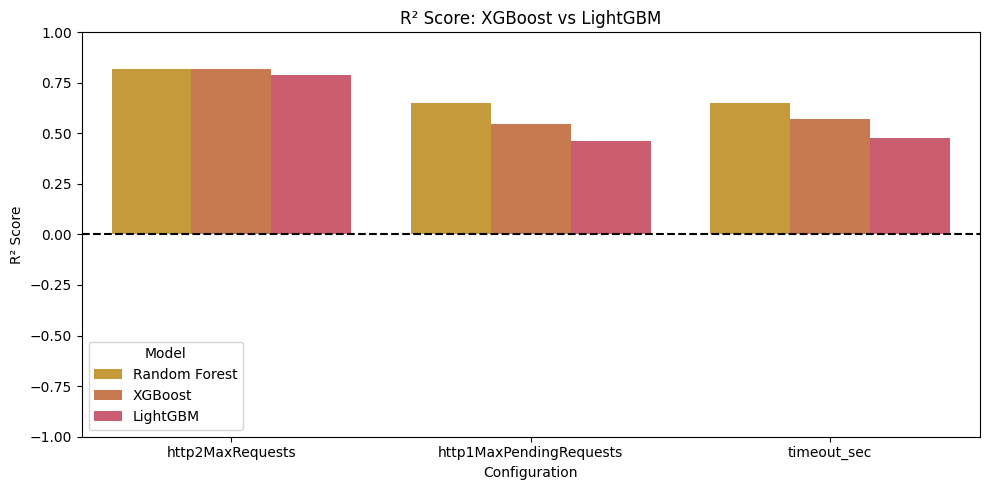

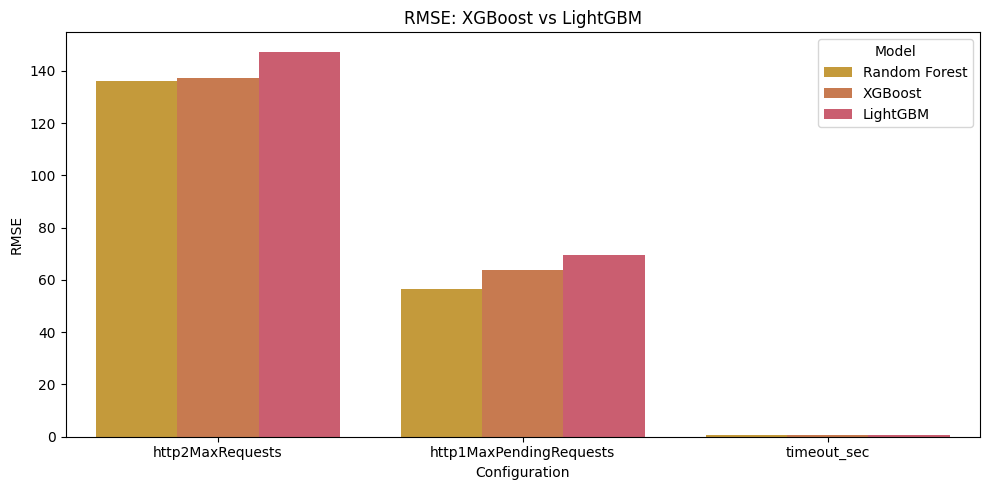

In [15]:
records = []
rf_results = {
    'http2MaxRequests': {'R2': 0.82, 'RMSE': 136.07},
    'http1MaxPendingRequests': {'R2': 0.65, 'RMSE': 56.37},
    'timeout_sec': {'R2': 0.65, 'RMSE': 0.60}
}
for model, result in [ ("Random Forest", rf_results), ("XGBoost", xgb_results), ("LightGBM", lgbm_results)]:
    for config, metrics in result.items():
        records.append({
            "Model": model,
            "Configuration": config,
            "R2": metrics["R2"],
            "RMSE": metrics["RMSE"]
        })

df = pd.DataFrame(records)

# Set consistent colors
palette = {
    "Random Forest": "#dba324",
    "XGBoost": "#db743c",
    "LightGBM": "#dc4c64"
}

# Plot R²
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x="Configuration", y="R2", hue="Model", palette=palette)
plt.title("R² Score: XGBoost vs LightGBM")
plt.ylabel("R² Score")
plt.ylim(-1, 1)
plt.axhline(0, color='black', linestyle='--')
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# Plot RMSE
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x="Configuration", y="RMSE", hue="Model", palette=palette)
plt.title("RMSE: XGBoost vs LightGBM")
plt.ylabel("RMSE")
plt.legend(title="Model")
plt.tight_layout()
plt.show()